# Trips and Streets

* Matching trip trajectories and São Paulo streets maps
* [Street shapefiles](http://geoftp.ibge.gov.br/recortes_para_fins_estatisticos/malha_de_setores_censitarios/censo_2010/base_de_faces_de_logradouros/): São Paulo code is `3550308`

Libraries and setup

In [1]:
import folium
import geopandas as gpd
from shapely.ops import cascaded_union
import json
from shapely.geometry import LineString
import time
import pandas as pd
import glob
import os
from matplotlib import pyplot as plt

folder = '../../data/sao-paulo/'
buffer_street = .0001
buffer_path = .00001

Buffer widths
* Consider thin trip paths and wide streets

In [3]:
def sao_paulo_map(zoom=12):
    return folium.Map([-23.5489, -46.6388], 
                      zoom_start=zoom, 
                      control_scale = True,
                      tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png', 
                      attr='&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> &copy; <a href="https://carto.com/attributions">CARTO</a>')

streets = gpd.read_file(folder + 'streets/35503087800_face.shp')
#streets = gpd.read_file(folder + 'streets/35503080100_face.shp')
extended = streets.buffer(buffer_street)
union = cascaded_union(extended)
streets = gpd.GeoDataFrame(geometry=gpd.GeoSeries(union))
sample_path = [[-47, -23.5489], [-46, -23.5489]]
sample_path = gpd.GeoDataFrame(geometry=[LineString(sample_path)]).buffer(buffer_path)
fmap = sao_paulo_map(zoom=14)
folium.GeoJson(streets.to_json()).add_to(fmap)
folium.GeoJson(sample_path.to_json(), style_function=lambda x: {'color': 'red'}).add_to(fmap)
fmap

Collection script
* Memory consumption is high
  * Processing trips in chunks
* After each finished chunk, a `.all` file is placed to avoid recomputing that chunk in case of some crash

In [4]:
def generate_line_geometry(row):
    lats = json.loads(row.lats)
    if len(lats) >= 2:
        longs = json.loads(row.longs)
        return LineString(zip(longs, lats))
    return None

def intersection_percent(row):
    return row.geometry_street.intersection(row.geometry_trip).area / row.geometry_trip.area

def collection_script():
    trip_chunk = 0
    for trips in pd.read_csv('../../../yellow/saida.csv', chunksize=50000):
        all_file = folder + 'tmp/' + str(trip_chunk) + '.all'
        if os.path.isfile(all_file): 
            print('Skipping chunk', trip_chunk)
            trip_chunk += 1
            continue

        print('Trip chunk', trip_chunk)
        start = time.time()
        
        trips['geometry'] = trips.apply(generate_line_geometry, axis=1)
        trips_geodf = gpd.GeoDataFrame(trips.tripid, geometry=trips.geometry)
        trips_geodf = trips_geodf[~trips_geodf.geometry.isnull()]
        trips_geodf = gpd.GeoDataFrame(trips_geodf.tripid, geometry=trips_geodf.buffer(buffer_path))

        trips_end = time.time()
        print(trips_end - start, 'seconds to generate trip buffers')

        for f in glob.glob(folder + 'streets/*_face.shp'):
            print('   ---', f)
            st_start = time.time()
            csv = folder + 'tmp/' + str(trip_chunk) + '-' + os.path.basename(f) + '.csv'
            if os.path.isfile(csv): continue

            streets = gpd.read_file(f)
            extended = streets.buffer(buffer_street)
            union = cascaded_union(extended)
            streets = gpd.GeoDataFrame(geometry=gpd.GeoSeries(union))
            intersections = gpd.sjoin(streets, trips_geodf, op='intersects')

            if len(intersections) == 0: 
                print('       No intersections')
                continue

            merge = intersections.merge(trips_geodf, on='tripid', suffixes=('_street', '_trip'))
            merge['intersect_perc'] = merge.apply(intersection_percent, axis=1)
            coverage = merge.groupby('tripid', as_index=False).agg({'intersect_perc': 'sum'})

            st_end = time.time()
            print('   ---', st_end - st_start, 'seconds to process trips vs streets chunk')
            coverage.to_csv(csv, index=False)

        f = open(all_file, 'w')
        f.close()
        trip_chunk += 1
        end = time.time()
        print('   ---', end - start, 'SECONDS ELAPSED')
        print()

collection_script()

Trip chunk 0


KeyboardInterrupt: 

Result fiies

In [5]:
"""
cv_files = glob.glob(folder + 'tmp/*.csv')
cv_list = []

for f in cv_files:
    cv = pd.read_csv(f)
    cv_list.append(cv)

street_coverage = pd.concat(cv_list)
street_coverage = street_coverage.groupby('tripid', as_index=False).agg({'intersect_perc': 'sum'})
street_coverage.to_csv(folder + 'yellow/streets-coverage.csv', index=False)
print(len(street_coverage), 'trips')
street_coverage.head(20)
"""
pass

In [2]:
# previously calculated file
street_coverage = pd.read_csv(folder + 'yellow/streets-coverage.csv')
print(len(street_coverage), 'trips')
street_coverage.head(20)

305094 trips


tripid  intersect_perc
0   00007439ba9f7da27a188eabe6cb99272a3dd4dfd680fc...        1.190331
1   0000851308f01d25a7d43d4fcccf74710b981c935ef1a2...        0.931902
2   0000e95296e68a819f154ac2ec5e56de68b4ee462e29bd...        1.000000
3   0000f754026ce07ad7be9826e2f5c040b1a55c296fb351...        1.000000
4   000127875189f827d83f9cefbc9c279e2f8362e8fcd1c8...        0.889862
5   00014258a55455da34e1b9ece4f0d789ef90d5599788fb...        0.548787
6   0001586b14f65233f33368d308e4970337a2392318b91d...        0.689329
7   0001883fea5f162bfc40e46ed9faa638eec20b987692d7...        0.955351
8   0001e4d8804d24e0f9dddd1cdd7d618740ac6dd39ea893...        0.912061
9   00020e959782a7422cc1cf2865895cfa164f83142d7234...        1.000000
10  0002f1ae32aa24b903eb235494d6b3ced6cda732f1b167...        1.000000
11  00032763de431ce3a7f718b08290c831c2e6def45597e8...        0.773919
12  0003342a0c7a74a9f9d029a711a34e8487bb7fbba5e600...        0.757244
13  0003343aadd0aea2fc68235679438e52d2188b4f993b4c...        1.006935
14  0003454fe3a86ace983373b9ca4f4907010dc1f7117291...        0.827077
15  0003bdee457609f135809d4f87fcae47d8c603e5dc8e60...        0.592983
16  0003c7e30607f50ef1b606183130f8b24f640f60686d95...        1.000000
17  000400156c19856b1f3d3c1adcadd1a35dc692ca634275...        0.899349
18  00044ce49ec04ecf09e48c7564ed1df315cecaf55c8a63...        0.994069
19  0004755840b0dcde5178113757b00a49bdee80db94bf57...        0.994730

Distribution

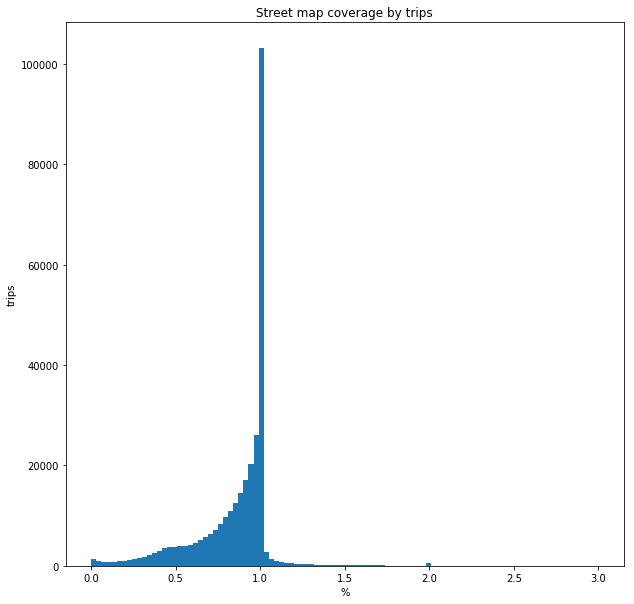

In [6]:
plt.figure(figsize=(10, 10))
plt.title('Street map coverage by trips')
plt.xlabel('%')
plt.ylabel('trips')
plt.hist(street_coverage.intersect_perc, bins=100)
plt.show()

Filtering

In [3]:
street_coverage[(street_coverage.intersect_perc >= 0.5) & (street_coverage.intersect_perc < 0.75)] \
        .to_csv('~/filter-low-intersection.csv', index=False)
street_coverage[street_coverage.intersect_perc < 0.5].to_csv('~/filter-very-low-intersection.csv', index=False)

Trajectories

In [ ]:
trips = pd.read_csv('~/saida.csv')
calculated = pd.read_csv('../../data/sao-paulo/yellow/calculated-variables.csv', parse_dates=['start_time'])
trips = trips.merge(calculated, on='tripid', how='left')
print(len(trips), 'trips')

Inspecting trips
* all kinds of strange values (very small, more than 1.0, etc.)

In [ ]:
#street_coverage[street_coverage.intersect_perc < 0.01]
trips[(trips.distance < 2000) & (trips.intersect_perc < 0.01)]

In [ ]:
selected = street_coverage.loc[12508]  # choose one
trip = trips[trips.tripid == selected.tripid]
trip = trip.loc[trip.index[0]]
display(trip)
lats = json.loads(trip.lats)
longs = json.loads(trip.longs)

fmap = sao_paulo_map()
folium.PolyLine(list(zip(lats, longs))).add_to(fmap)
fmap